# Modeling


## import packages

In [15]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['font.family'].insert(0, 'Malgun Gothic')
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## load data/ preprocess

In [16]:
ex = pd.read_csv('data_0010VDS00800.csv', encoding='euc-kr')

In [17]:
ex = ex[['이전VDS', '이후VDS', 'holiday', '교통량', '평균속도' ] ]

In [18]:
look_back_size = 4
output_size = 4
train_size = 0.7

In [19]:
def create_dataset(array, look_back=4, output_size=4):
    # input 데이터를 time-step(=4) 만큼 전진하면서 분할
    X = []
    for i in range(len(array)-look_back-(output_size-1)):
        X.append(array[i:(i+look_back)])
    return np.array(X)

In [20]:
# ex) 전체 데이터 1행부터4행까지 + y변수 5행~8행이 한 세트
# 데이터프레임을 np.array로 변환후 함수 적용
Y = ex.평균속도
Y = np.array(Y)

In [21]:
ex = np.array(ex)
X = create_dataset(ex)
Y = create_dataset(Y)

In [22]:
print(X.shape)
print(Y.shape)

(1337, 4, 5)
(1337, 4)


## train-test split 

In [23]:
X_train_, X_test_ = X[:round(len(X)*train_size),:], X[round(len(X)*train_size):,:]
y_train, y_test = Y[:round(len(Y)*train_size),:], Y[round(len(Y)*train_size):,:]

In [24]:
X_train = X_train_.reshape(X_train_.shape[0], X_train_.shape[1], -1)
X_test = X_test_.reshape(X_test_.shape[0], X_test_.shape[1], -1)

In [25]:
print(X_train.shape)
print(y_train.shape)

(936, 4, 5)
(936, 4)


In [26]:
print(X_test.shape)
print(y_test.shape)

(401, 4, 5)
(401, 4)


## LSTM Model

In [27]:
verbose, epochs, batch_size = 0, 200, 12
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [28]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(20, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(n_outputs))

opt = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='mse', optimizer=opt)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                2080      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 44        
Total params: 2,334
Trainable params: 2,334
Non-trainable params: 0
_________________________________________________________________


In [29]:
hist = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Instructions for updating:
Use tf.cast instead.


## evaluation 

In [30]:
y_pred = model.predict(X_test)
y_pred

array([[ 96.96229 ,  96.122314,  96.892815,  96.52601 ],
       [ 99.69486 ,  98.70509 ,  99.606255,  99.24273 ],
       [ 99.81519 ,  98.78479 ,  99.720146,  99.36258 ],
       ...,
       [102.89416 , 102.48563 , 102.90775 , 102.41862 ],
       [102.47743 , 102.10501 , 102.496124, 102.00422 ],
       [101.01728 , 100.4233  , 100.99653 , 100.554474]], dtype=float32)

In [31]:
y_test

array([[ 90.54,  97.05,  99.93,  99.87],
       [ 97.05,  99.93,  99.87, 100.48],
       [ 99.93,  99.87, 100.48,  95.92],
       ...,
       [104.12, 104.38,  98.08, 101.55],
       [104.38,  98.08, 101.55, 101.67],
       [ 98.08, 101.55, 101.67, 102.39]])

In [32]:
from sklearn.metrics import mean_squared_error

print('first step: ', mean_squared_error(y_test[:,0], y_pred[:,0]))
print('second step: ', mean_squared_error(y_test[:,1], y_pred[:,1]))
print('third step: ', mean_squared_error(y_test[:,2], y_pred[:,2]))
print('fourth step:', mean_squared_error(y_test[:,3], y_pred[:,3]))

first step:  18.34171781389909
second step:  12.7711695675175
third step:  15.257118897016824
fourth step: 22.80827100166611


## visualization

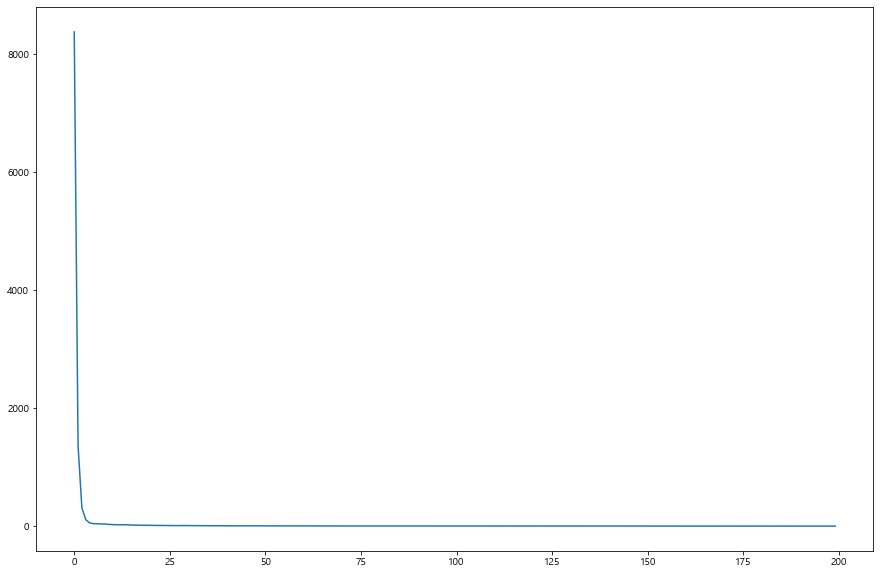

In [34]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(range(200), hist.history['loss'])

In [35]:
y_pred_00 = [i[0] for i in y_pred]
y_pred_15 = [i[1] for i in y_pred]
y_pred_30 = [i[2] for i in y_pred]
y_pred_45 = [i[-1] for i in y_pred]

y_test_00 = [i[0] for i in y_test]
y_test_15 = [i[1] for i in y_test]
y_test_30 = [i[2] for i in y_test]
y_test_45 = [i[3] for i in y_test]

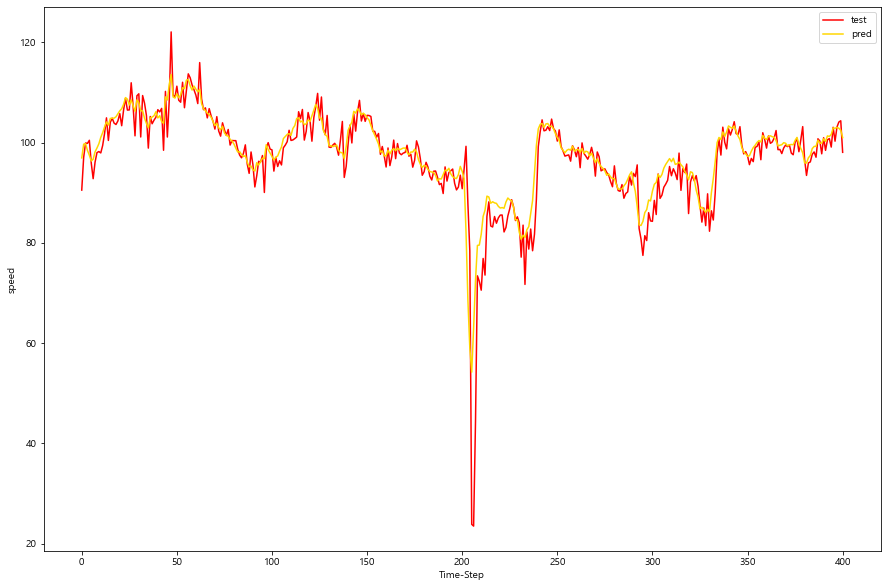

In [36]:
#plt.rcParams["figure.figsize"] = (20,10)
plt.figure(1)
plt.plot(range(401),y_test_00, color= 'r', label='test')
plt.plot(range(401),y_pred_00, color='gold',label='pred')
plt.xlabel('Time-Step')
plt.ylabel('speed')
plt.legend()